In [2]:
import time
import math
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt

import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Reshape, LeakyReLU

In [3]:
import glob
import imageio
import os
import PIL
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

BASE_DRIVE_PATH = "/content/drive/MyDrive/colab_files/GAN_with_Noise_Injection"

# data selection

get data in dataset as np array

## DOT_SCATTER_DATA

In [4]:
DOT_TEST = []
n=8
for i in range(n):
  x=math.cos(i*math.pi*2/n)
  y=math.sin(i*math.pi*2/n)
  for j in range(1000):
    DOT_TEST.append([x+np.random.normal(0,0.02),y+np.random.normal(0,0.02)])

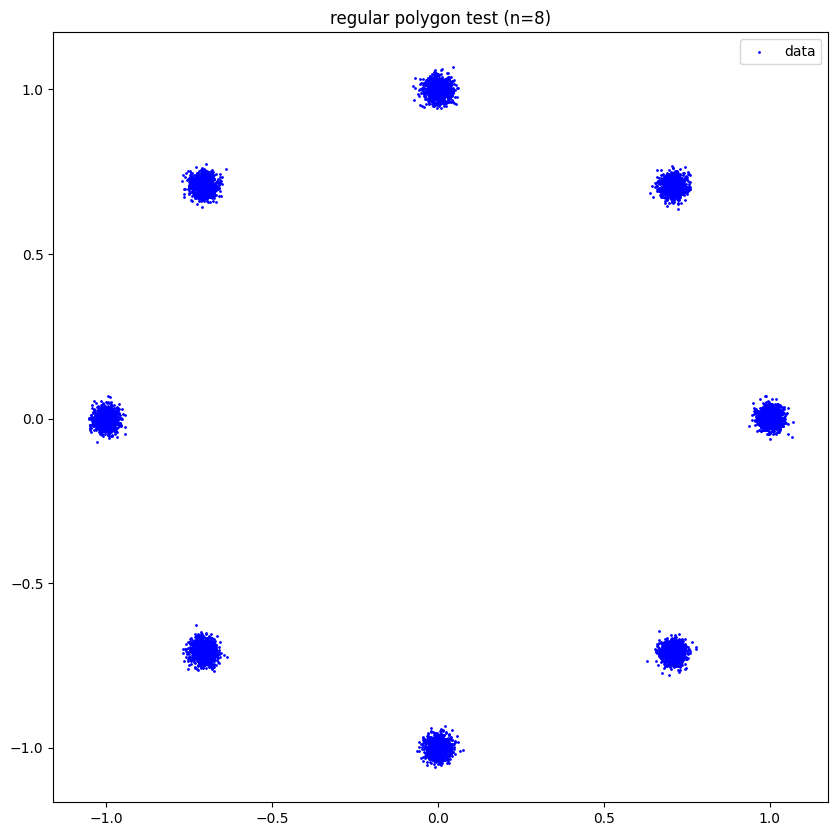

In [5]:
plt.figure(figsize=(10, 10))
plt.scatter(np.array(DOT_TEST)[:,0],np.array(DOT_TEST)[:,1],color='b',s=1,label="data")
plt.title(f'regular polygon test (n={n})')
plt.legend()
plt.show()

In [6]:
DOT_TEST_dataset=np.array(DOT_TEST)
DOT_TEST_dataset=DOT_TEST_dataset.reshape(DOT_TEST_dataset.shape[0],2,1).astype('float32')
DOT_TEST_dataset.shape

(8000, 2, 1)

## MNIST_DATA

In [68]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [69]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
MNIST_TEST_dataset = train_images
MNIST_TEST_dataset.shape

(60000, 28, 28, 1)

# setting

In [162]:
EPOCH = 50
BATCH_SIZE = 16
BUFFER_SIZE = 50000
LEARNING_RATE = 3e-4

NOISE_DIM = 4

SEED = 79             #UC 0079

DATASET = DOT_TEST_dataset
NOISE_RATE_SCHEDULE = np.linspace(0.30,0,EPOCH)

In [122]:
EPOCH = 50
BATCH_SIZE = 256
BUFFER_SIZE = 50000
LEARNING_RATE = 6e-4

NOISE_DIM = 100

SEED = 79             #UC 0079
#seed = tf.random.normal(79,0)

#change this section to set dataset and noise_rate_schedule

DATASET = MNIST_TEST_dataset
NOISE_RATE_SCHEDULE = np.linspace(0.30,0,EPOCH)

In [72]:
DATA_MEAN = tf.constant(np.mean(DATASET, axis=0),dtype=DATASET.dtype)
DATA_STD = tf.constant(np.std(DATASET, axis=0),dtype=DATASET.dtype)

DATA_SHAPE = DATASET[0].shape

train_dataset = tf.data.Dataset.from_tensor_slices(DATASET).shuffle(BUFFER_SIZE,seed=SEED).batch(BATCH_SIZE)
train_noise_rate_schedule = tf.constant(NOISE_RATE_SCHEDULE,dtype=DATASET.dtype)

## DOT_TEST

In [169]:
def DOT_TEST_generator():
  model = keras.Sequential()
  model.add(layers.Dense(16, use_bias=False, kernel_regularizer='l2', input_shape=(NOISE_DIM,)))
  model.add(layers.LeakyReLU())
  model.add(layers.Dense(8, use_bias=False, kernel_regularizer='l2'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dense(4, use_bias=False, activation='tanh', kernel_regularizer='l2'))
  model.add(layers.Dense(2, use_bias=False, activation='tanh', kernel_regularizer='l2'))
  return model

In [170]:
def DOT_TEST_discriminator():
  model = tf.keras.Sequential()
  model.add(layers.Dense(8, input_shape=DATA_SHAPE))
  model.add(layers.LeakyReLU())

  model.add(layers.Dense(8))
  model.add(layers.LeakyReLU())

  model.add(layers.Dense(4))
  model.add(layers.LeakyReLU())

  model.add(layers.Dense(1))
  return model

## MNIST_TEST

In [168]:
def MNIST_TEST_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(NOISE_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [152]:
def MNIST_TEST_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=DATA_SHAPE))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# train defintion

In [171]:
#change this section to set generator and discriminator
G = DOT_TEST_generator()
D = DOT_TEST_discriminator()
#G = MNIST_TEST_generator()
#D = MNIST_TEST_discriminator()
#===============================================================================================

G_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
D_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def G_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

def D_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

#===============================================================================================

@tf.function
def apply_noise(data, noise_rate):
  noise = tf.random.normal(shape=tf.shape(data), mean = DATA_MEAN, stddev = DATA_STD, seed = SEED, dtype = DATASET.dtype)
  noised_data = (1-noise_rate) * data + noise_rate * noise
  return noised_data

@tf.function
def train_batch(data, noise_rate):
    z = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    noised_data = apply_noise(data, noise_rate)

    with tf.GradientTape() as G_tape, tf.GradientTape() as D_tape:
      generated_data = G(z, training=True)

      real_output = D(noised_data, training=True)
      fake_output = D(generated_data, training=True)

      g_loss = G_loss(fake_output)
      d_loss = D_loss(real_output, fake_output)

    gradients_of_g = G_tape.gradient(g_loss, G.trainable_variables)
    gradients_of_d = D_tape.gradient(d_loss, D.trainable_variables)

    g_norm = tf.linalg.global_norm(gradients_of_g)
    d_norm = tf.linalg.global_norm(gradients_of_d)

    G_optimizer.apply_gradients(zip(gradients_of_g, G.trainable_variables))
    D_optimizer.apply_gradients(zip(gradients_of_d, D.trainable_variables))

    return g_loss, d_loss, g_norm, d_norm

#===============================================================================================

def record(log, log_data):
  for box, item in zip(log, log_data):
    box.append(item)

def train(dataset, epoch, noise_rate_schedule = None, num_G_sample = 0, seed = None):
  if noise_rate_schedule == None:
    noise_rate_schedule = tf.constant(np.zeros(epoch), DATASET.dtype)

  log = [[],[],[],[]]
  sample = []
  sample_seed = tf.random.normal([num_G_sample, NOISE_DIM], seed = seed)
  count = 1

  for noise_rate in noise_rate_schedule:
    start = time.time()

    for data in dataset:
      g_loss, d_loss, g_norm, d_norm = train_batch(data, noise_rate)
      record(log, [g_loss, d_loss, g_norm, d_norm])

    sample.append(G(sample_seed, training=False))
    print(f"epoch : {count} / time : {time.time()-start} / g_loss : {g_loss} / d_loss : {d_loss}")
    count+=1

  return log, sample

## DOT_SCATTER noise apply example

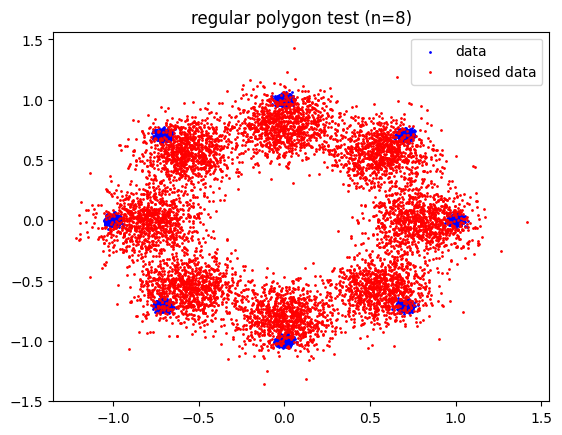

In [88]:
gamma=0.2
plt.scatter(np.array(DATASET)[:,0],np.array(DATASET)[:,1],color='b',s=1,label="data")
plt.scatter(np.array(apply_noise(DATASET, tf.constant(gamma)))[:,0],np.array(apply_noise(DATASET, tf.constant(gamma)))[:,1],color='r',s=1,label="noised data")
plt.title(f'regular polygon test (n={n})')
plt.legend()
plt.show()

## MNIST noise apply example

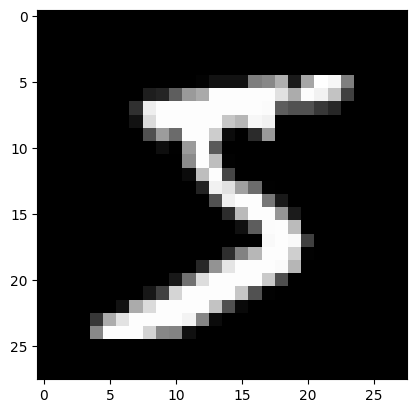

ValueError: in user code:

    File "/tmp/ipython-input-872675848.py", line 26, in apply_noise  *
        noise = tf.random.normal(shape=tf.shape(data), mean = DATA_MEAN, stddev = DATA_STD, seed = SEED, dtype = DATASET.dtype)

    ValueError: Dimensions must be equal, but are 28 and 2 for '{{node random_normal/mul}} = Mul[T=DT_FLOAT](random_normal/RandomStandardNormal, random_normal/stddev)' with input shapes: [1,28,28,1], [2,1].


In [89]:
gamma=0.3
plt.imshow(train_images[0,:,:,0]*127.5+127.5, cmap='gray')
plt.show()
plt.imshow(apply_noise(train_images[0:1], tf.constant(gamma))[0,:,:,0]*127.5+127.5, cmap='gray')
plt.show()

# train

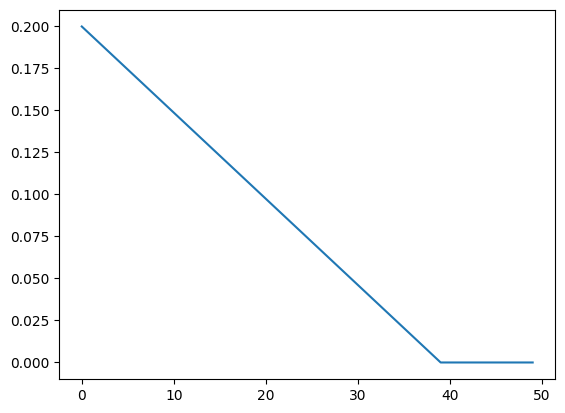

In [94]:
NOISE_RATE_SCHEDULE=np.concatenate((np.linspace(0.20,0,EPOCH-10),np.zeros(10)))
plt.plot(NOISE_RATE_SCHEDULE)

In [95]:
train_noise_rate_schedule = tf.constant(NOISE_RATE_SCHEDULE,DATASET.dtype)

In [172]:
log, sample = train(train_dataset, EPOCH, train_noise_rate_schedule, num_G_sample = 16, seed = SEED)
#log, sample = train(train_dataset, EPOCH, num_G_sample = 16, seed = SEED)

epoch : 1 / time : 2.8424015045166016 / g_loss : 0.6960269212722778 / d_loss : 1.3751311302185059
epoch : 2 / time : 1.016021728515625 / g_loss : 0.7001566290855408 / d_loss : 1.4013590812683105
epoch : 3 / time : 0.9867842197418213 / g_loss : 0.6994012594223022 / d_loss : 1.368062973022461
epoch : 4 / time : 0.9837024211883545 / g_loss : 0.6918602585792542 / d_loss : 1.3789557218551636
epoch : 5 / time : 0.9762918949127197 / g_loss : 0.699954628944397 / d_loss : 1.386810541152954
epoch : 6 / time : 0.9843242168426514 / g_loss : 0.6772449016571045 / d_loss : 1.3978683948516846
epoch : 7 / time : 0.9829351902008057 / g_loss : 0.6899979114532471 / d_loss : 1.3841619491577148
epoch : 8 / time : 0.9833579063415527 / g_loss : 0.690981924533844 / d_loss : 1.3829185962677002
epoch : 9 / time : 0.9950141906738281 / g_loss : 0.6912862062454224 / d_loss : 1.384835958480835
epoch : 10 / time : 1.0045647621154785 / g_loss : 0.7056598663330078 / d_loss : 1.377115249633789
epoch : 11 / time : 0.9828

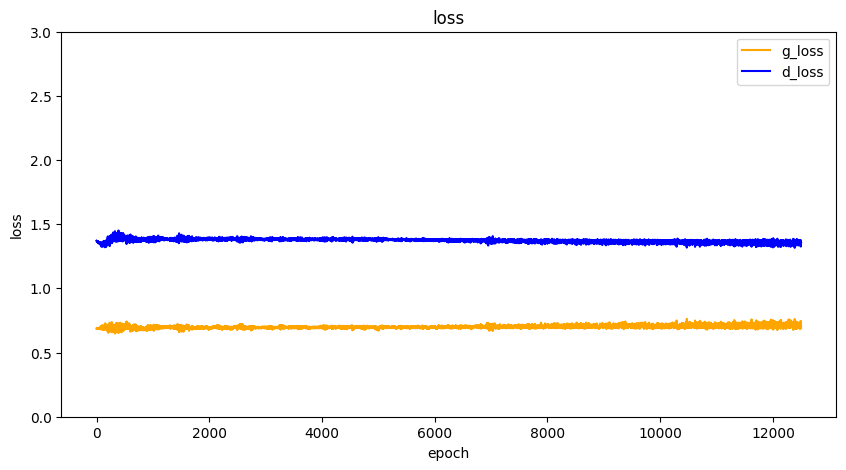

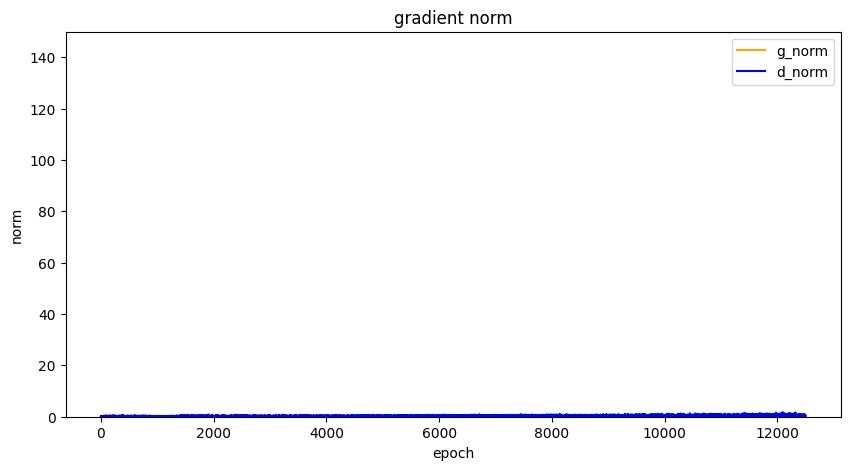

In [173]:
plt.figure(figsize=(10, 5))
plt.ylim(0, 3)
plt.plot(log[0],label="g_loss", color = 'orange')
plt.plot(log[1],label="d_loss", color = 'blue')
plt.title(f'loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.ylim(0, 150)
plt.plot(log[2],label="g_norm", color = 'orange')
plt.plot(log[3],label="d_norm", color = 'blue')
plt.title(f'gradient norm')
plt.xlabel("epoch")
plt.ylabel("norm")
plt.legend()
plt.show()

# sample visualization

## DOT_SCATTER

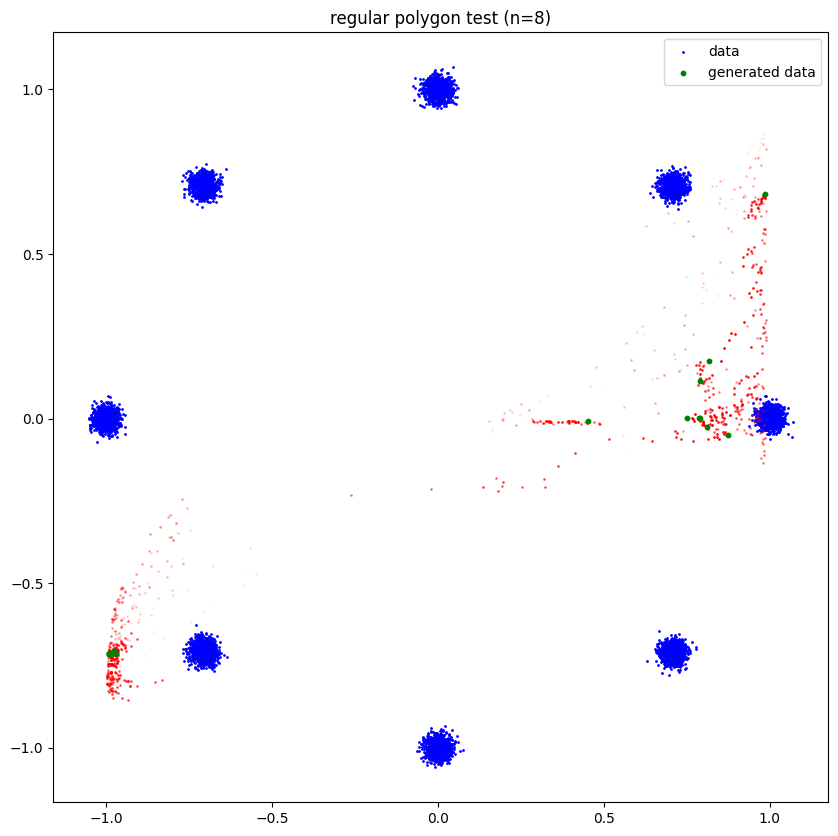

In [174]:
plt.figure(figsize=(10, 10))
plt.scatter(np.array(DOT_TEST)[:,0],np.array(DOT_TEST)[:,1],color='b',s=1,label="data")
for i in range(EPOCH):
  plt.scatter(np.array(sample[i])[:,0],np.array(sample[i])[:,1],color='r', alpha=(i+1)/EPOCH, s=1)#label="generated data"
plt.scatter(np.array(sample[EPOCH-1])[:,0],np.array(sample[EPOCH-1])[:,1],color='g', s=10, label="generated data")
plt.title(f'regular polygon test (n={n})')
plt.legend()
plt.show()

## MNIST

In [ ]:
for img_set in sample:
  fig = plt.figure(figsize=(4, 4))
  for i in range(img_set.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(img_set[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

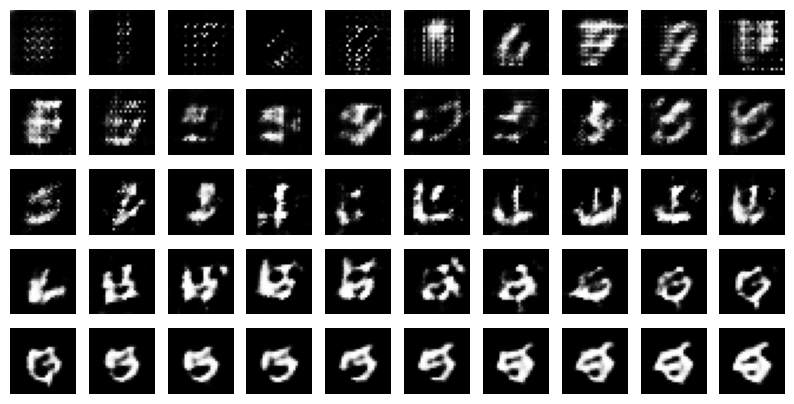

In [ ]:
sample_num = 14
start_EPOCH = 0
end_EPOCH = 50

x = 10
y = math.ceil((end_EPOCH - start_EPOCH)/x)
fig = plt.figure(figsize=(x, y))

for i in range(end_EPOCH - start_EPOCH):
  plt.subplot(y, x, i+1)
  plt.imshow((sample[i + start_EPOCH])[sample_num, :, :, 0] * 127.5 + 127.5, cmap='gray')
  plt.axis('off')
plt.show()


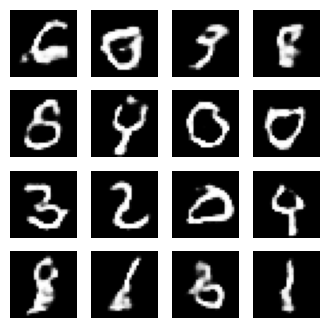

In [ ]:
#generate random sample
z=tf.random.normal([16, NOISE_DIM])
test_sample=G(z, training=False)

fig = plt.figure(figsize=(4, 4))
for i in range(test_sample.shape[0]):
  plt.subplot(4, 4, i+1)
  plt.imshow(test_sample[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
  plt.axis('off')
plt.show()

In [ ]:
#continuous path from sample A to B
SPLIT = 20   # SPLIT > 1

z_A=tf.random.normal([1, NOISE_DIM])
z_B=tf.random.normal([1, NOISE_DIM])

fig = plt.figure(figsize=(SPLIT, 1))

for i in range(SPLIT):
  z = z_A + (z_B - z_A) * i / (SPLIT-1)
  test_sample = G(z, training=False)
  plt.subplot(1, SPLIT, i+1)
  plt.imshow(test_sample[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
  plt.axis('off')
plt.show()

NameError: name 'tf' is not defined

# generator visualization